<a href="https://colab.research.google.com/github/IsraelVitorNSantos/TB_Final/blob/main/Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final - OSEMN

## 1. **O**btain (Obter)

Importando as bibliotecas necessárias

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date, time, datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Fazendo a leitura das bases de dados

In [ ]:
# Faz a conexão com o Google Drive
drive.mount('/content/drive')
# Faz a leitura da Parte 1 da base de dados do RU
parte1 = pd.read_csv("/content/drive/MyDrive/Dataset-RU/Parte-I.csv", sep = ";")
# Faz a leitura da Parte 2 da base de dados do RU
parte2 = pd.read_csv("/content/drive/MyDrive/Dataset-RU/Parte-II.csv")
# Faz a leitura da Parte 3 da base de dados do RU
parte3 = pd.read_csv("/content/drive/MyDrive/Dataset-RU/Parte-III.csv")

MessageError: ignored

Exibindo as primeiras 5 linhas da base de dados "parte1" para averiguar se a leitura foi feita corretamente

In [ ]:
parte1.head()

Exibindo as primeiras 5 linhas da base de dados "parte2" para averiguar se a leitura foi feita corretamente

In [ ]:
parte2.head()

Exibindo as primeiras 5 linhas da base de dados "parte3" para averiguar se a leitura foi feita corretamente

In [ ]:
parte3.head()

## 2. **S**crub (Limpeza)

A base de dados "parte1" possui os nomes das colunas diferentes das demais partes, isso causará um problema no momento de agrupar todas elas. Por conta disso, será necessário renomeá-las.

In [ ]:
# Renomeia as colunas da base de dados "parte1"
parte1 = parte1.rename(columns={'date': 'Data', 'lunch': 'Qt_almoco', 'dinner': 'Qt_jantar'})
# Exibe as primeiras 5 linhas da base de dados "parte1" após a renomeação das colunas
parte1.head()

,Data,Qt_almoco,Qt_jantar
0,2016-01-04,364,294
1,2016-01-05,489,363
2,2016-01-06,522,401
3,2016-01-07,514,349
4,2016-01-08,409,218


A base de dados "parte3" possui uma coluna a mais do que deveria, no caso se trata da primeira coluna "Unnamed: 0". Para que seja feito o agrupamentos com as demais partes é preciso remover essa coluna

In [ ]:
# Removendo a primeira coluna da base de dados "parte3"
parte3 = parte3.drop(columns=['Unnamed: 0'])
# Exibe as primeiras 5 linhas da base de dados "parte3" após a remoção da primeira coluna
parte3.head()

,Data,Qt_almoco,Qt_jantar
0,2018-01-02,0,0
1,2018-01-03,0,0
2,2018-01-04,0,0
3,2018-01-05,0,0
4,2018-01-08,69,0


Uma vez que todas as partes estão com o mesmo número de colunas, podemos fazer o agrupamento de todas elas

In [ ]:
# Junta todas as 3 partes em uma única base de dados
base_final = pd.concat([parte1, parte2, parte3], ignore_index=True)


# Exibe a base de dados final
base_final

,Data,Qt_almoco,Qt_jantar
0,2016-01-04,364,294
1,2016-01-05,489,363
2,2016-01-06,522,401
3,2016-01-07,514,349
4,2016-01-08,409,218
...,...,...,...
1265,2020-03-25,0,0
1266,2020-03-26,11,13
1267,2020-03-27,15,14
1268,2020-03-30,13,12


É possível perceber que na base de dados final possui linhas onde ambas as colunas "Qt_almoco" e "Qt_jantar" possuem valor igual à 0, podendo assim serem removidas, uma vez que se tratam de dias onde o RU não serviu nenhuma refeição.

In [ ]:
# Laço de repetição que irá percorrer todas as linhas da "base_final"
for i in range(len(base_final)):
  # Condição caso tanto a coluna "Qt_almoco" quanto a "Qt_jantar" tenham valor igual a 0
  if(base_final['Qt_almoco'][i] == 0 & base_final["Qt_jantar"][i] == 0):
    # Caso ambas as colunas sejam possuam valor 0, a linha será removida
    base_final.drop(i, inplace=True)

# Uma vez removida todas as linhas, é preciso resetar o index para corresponder ao novo número de linhas da base final
base_final = base_final.reset_index(drop=True)

# Exibindo a base final depois de todas as modificações
base_final

# Gerando uma copia da base_final para uso posterior
base_final_copia = base_final.copy()

## 3. **E**xplore (Exploração)



Verificando as propriedades da base de dados final

In [ ]:
# Verifica quais são os tipo das colunas
base_final.dtypes

Data         object
Qt_almoco     int64
Qt_jantar     int64
dtype: object

Todos os tipos estão de acordo, a coluna "Data" está como string e os valores de "Qt_almoco" e "Qt_jantar" estão como inteiro. Dessa forma, não será necessário fazer nenhuma modificação durante o processo de exploração dos dados.

## 4. **M**odel (Modelagem)

###Análise Quantidade de Almoço utilizando Regressão Linear e Floresta Aleatória

In [ ]:
base_final.Data = pd.to_datetime(base_final.Data) # Convertendo a coluna Data para o formata de data
base_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Data       1148 non-null   datetime64[ns]
 1   Qt_almoco  1148 non-null   int64         
 2   Qt_jantar  1148 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 27.0 KB


In [ ]:
base_final['ano'] = base_final.Data.dt.year
base_final['mes'] = base_final.Data.dt.month
base_final['dia'] = base_final.Data.dt.dayofweek

In [ ]:
base_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Data       1148 non-null   datetime64[ns]
 1   Qt_almoco  1148 non-null   int64         
 2   Qt_jantar  1148 non-null   int64         
 3   ano        1148 non-null   int64         
 4   mes        1148 non-null   int64         
 5   dia        1148 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 53.9 KB


Objetivo: Desenvolver algumas técnicas de regressão e séries temporais
nos dados para avaliar qual o melhor modelo de análise dos mesmos.


In [ ]:
base_final.describe()

,Qt_almoco,Qt_jantar,ano,mes,dia
count,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000
mean,570.296167,335.040941,2017.706446,6.022648,1.984321
std,279.351140,215.312767,1.145124,3.317730,1.411041
min,9.000000,0.000000,2016.000000,1.000000,0.000000
25%,246.750000,102.750000,2017.000000,3.000000,1.000000
50%,671.500000,409.500000,2018.000000,6.000000,2.000000
75%,793.000000,507.000000,2019.000000,9.000000,3.000000
max,1033.000000,714.000000,2020.000000,12.000000,4.000000


####Matriz de Correlação
  O coeficiente de correlação é uma medida de associação entre duas variáveis e situa-se entre -1 e 1 sendo que -1 indica associação negativa perfeita e 1 indica associação positiva perfeita

In [ ]:
base_final.corr()

,Qt_almoco,Qt_jantar,ano,mes,dia
Qt_almoco,1.000000,0.971621,-0.026467,0.293104,-0.088697
Qt_jantar,0.971621,1.000000,-0.070353,0.315725,-0.174988
ano,-0.026467,-0.070353,1.000000,-0.165539,0.006861
mes,0.293104,0.315725,-0.165539,1.000000,-0.012029
dia,-0.088697,-0.174988,0.006861,-0.012029,1.000000


Estimar um modelo de Machine Learing utilizando a técnica de Regresão Linear para demonstrar os impactos das variáveis disponibilizadas neste dataset sobre a quantidade de almoco e jantar (Y's). NO final do projeto teremos umm modelo de previsão para o consumo médio de almoço segundo os inputs de da variável X.

In [ ]:
base_final.shape

(1148, 6)

#### Comportamento da Variável Dependente(Y)
Análises Gráficas

In [ ]:
sns.set_palette("Accent")
sns.set_style("darkgrid")

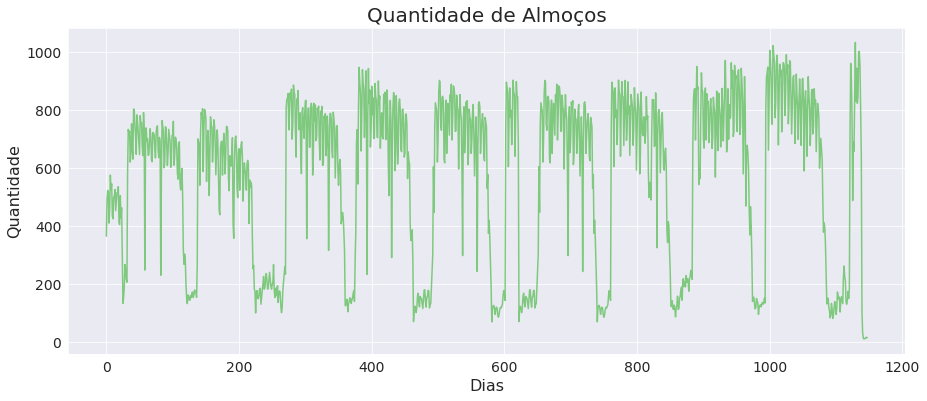

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_title('Quantidade de Almoços',fontsize=20)
ax.set_ylabel('Quantidade', fontsize=16)
ax.set_xlabel('Dias', fontsize=16)
ax = base_final['Qt_almoco'].plot(fontsize=14)

Modelos de regressão linear assumem, inicialmente, que a variável dependente segue uma distribuição normal.

Text(0, 0.5, 'Quantidade')

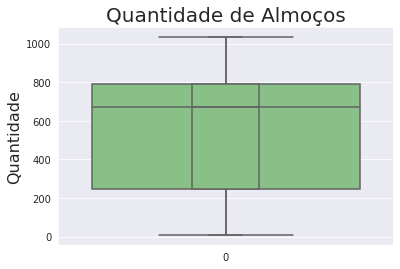

In [ ]:
sns.boxplot(data=base_final['Qt_almoco'])
ax = sns.boxplot(data=base_final['Qt_almoco'], orient='v', width=0.2)
ax.set_title('Quantidade de Almoços',fontsize=20)
ax.set_ylabel('Quantidade', fontsize=16)

Text(0.5, 0, 'Dia da Semana')

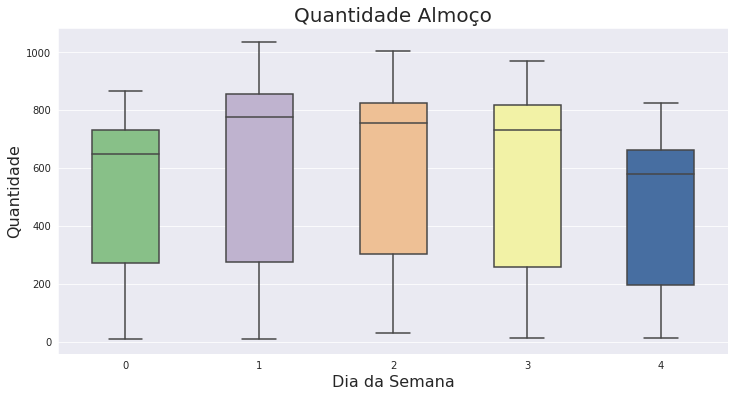

In [ ]:
ax = sns.boxplot(y='Qt_almoco', x='dia', data=base_final, orient='v', width=0.5)
ax.figure.set_size_inches(12, 6)
ax.set_title('Quantidade Almoço', fontsize=20)
ax.set_ylabel('Quantidade', fontsize=16)
ax.set_xlabel('Dia da Semana', fontsize=16)       # 0 representa segunda até 4 que representa sexta-feira.

Text(0.5, 0, 'Mes')

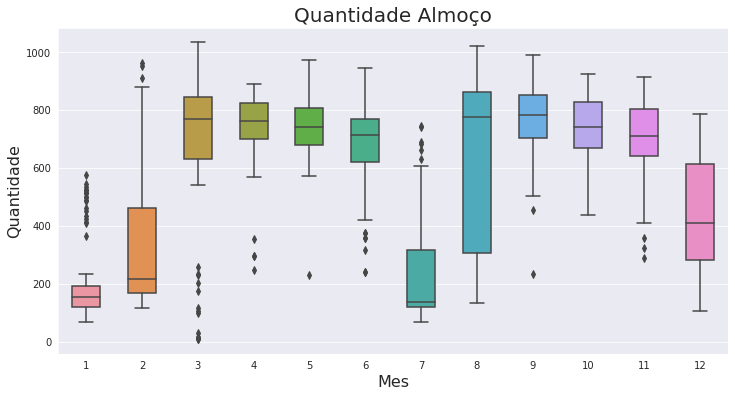

In [ ]:
ax = sns.boxplot(y='Qt_almoco', x='mes', data=base_final, orient='v', width=0.5)
ax.figure.set_size_inches(12, 6)
ax.set_title('Quantidade Almoço', fontsize=20)
ax.set_ylabel('Quantidade', fontsize=16)
ax.set_xlabel('Mes', fontsize=16)

Text(0.5, 0, 'Ano')

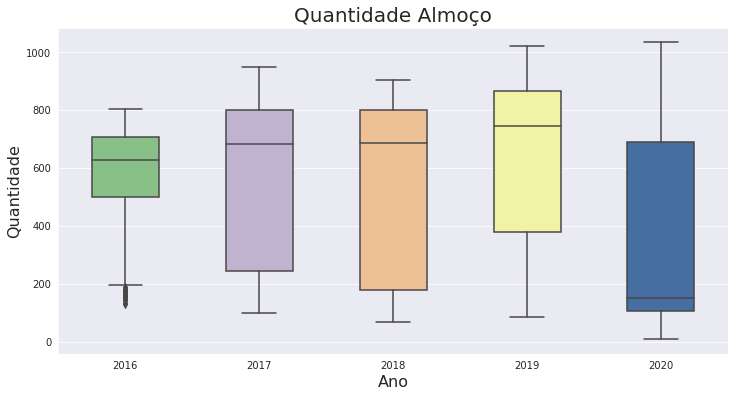

In [ ]:
ax = sns.boxplot(y='Qt_almoco', x='ano', data=base_final, orient='v', width=0.5)
ax.figure.set_size_inches(12, 6)
ax.set_title('Quantidade Almoço', fontsize=20)
ax.set_ylabel('Quantidade', fontsize=16)
ax.set_xlabel('Ano', fontsize=16)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Quantidade')

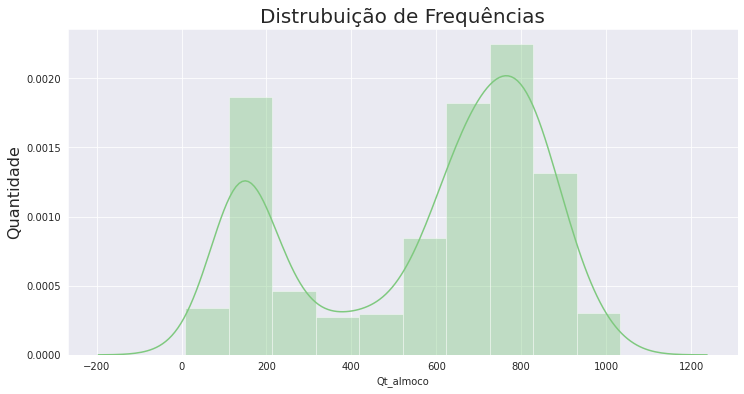

In [ ]:
ax = sns.distplot(base_final['Qt_almoco'])
ax.figure.set_size_inches(12, 6)
ax.set_title('Distrubuição de Frequências', fontsize=20)
ax.set_ylabel('Quantidade', fontsize=16)

 Análise gráfica de variáveis dependentes e variáveis explicativas.

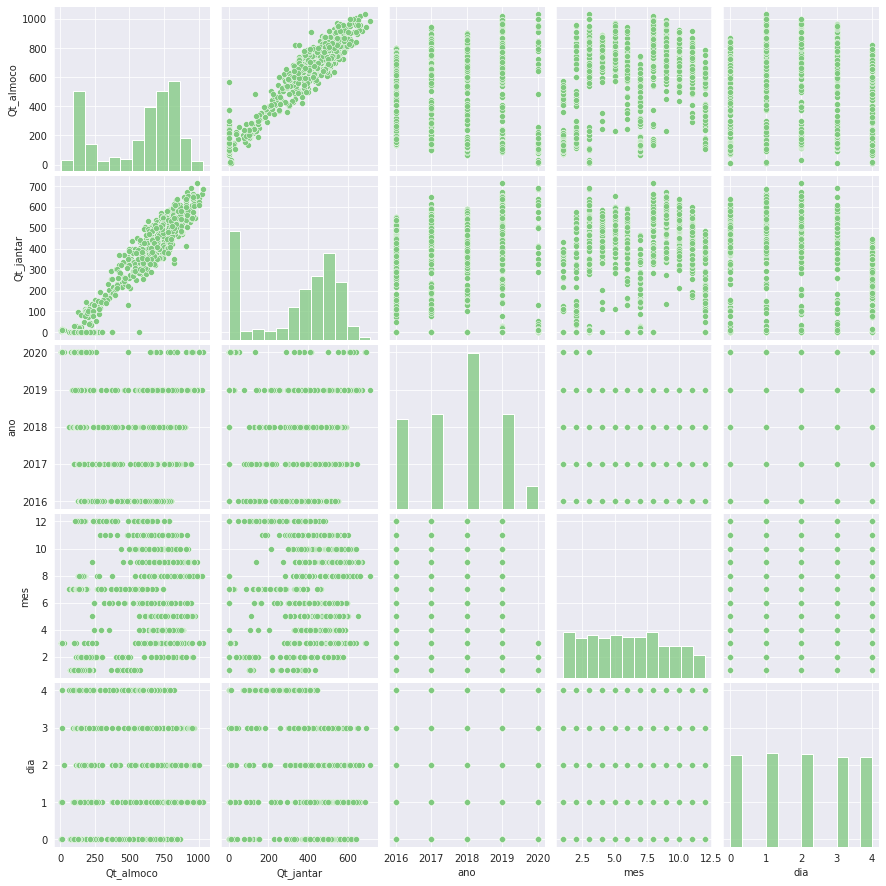

In [ ]:
ax = sns.pairplot(base_final)

Text(0.5, 1.05, 'Dispersão entre as Variáveis')

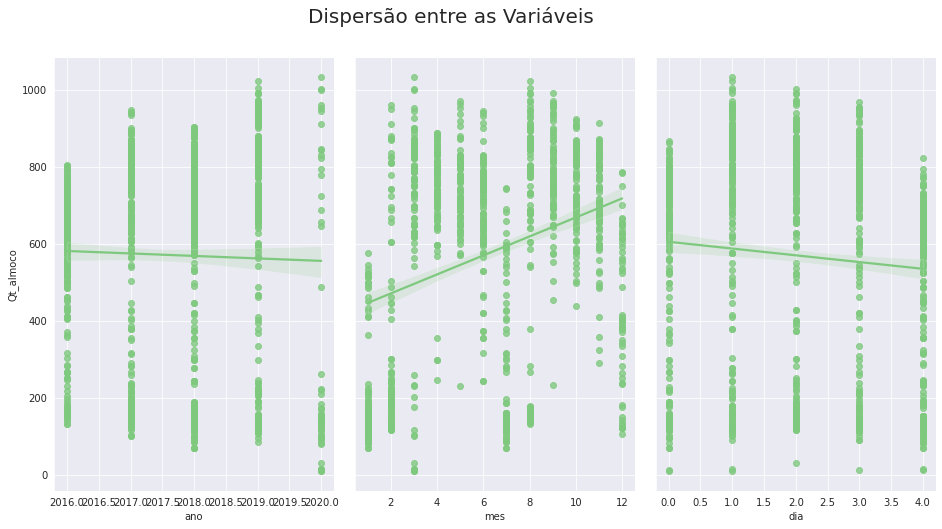

In [ ]:
ax = sns.pairplot(base_final, y_vars='Qt_almoco', x_vars=['ano', 'mes','dia'],kind='reg')
ax.figure.set_size_inches(14, 8)
ax.fig.suptitle('Dispersão entre as Variáveis', fontsize=20, y=1.05)

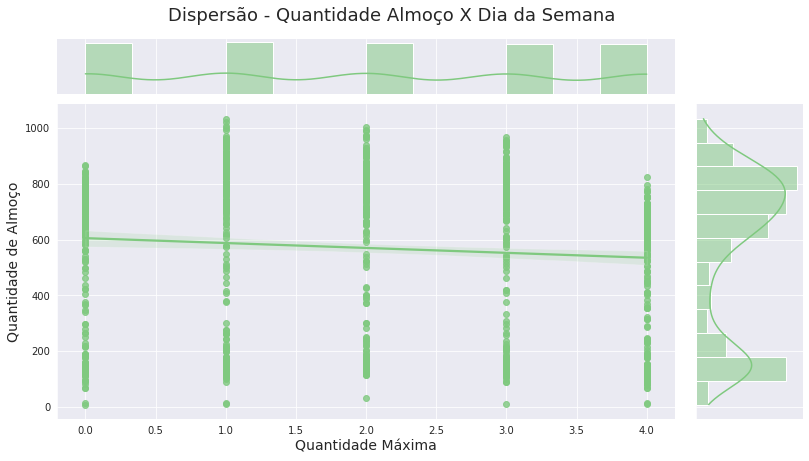

In [ ]:
ax = sns.jointplot(x="dia", y="Qt_almoco", data=base_final, kind='reg')
ax.fig.suptitle('Dispersão - Quantidade Almoço X Dia da Semana', fontsize=18, y=1.05)
ax.set_axis_labels("Quantidade Máxima", "Quantidade de Almoço", fontsize=14)
ax.figure.set_size_inches(12,6)

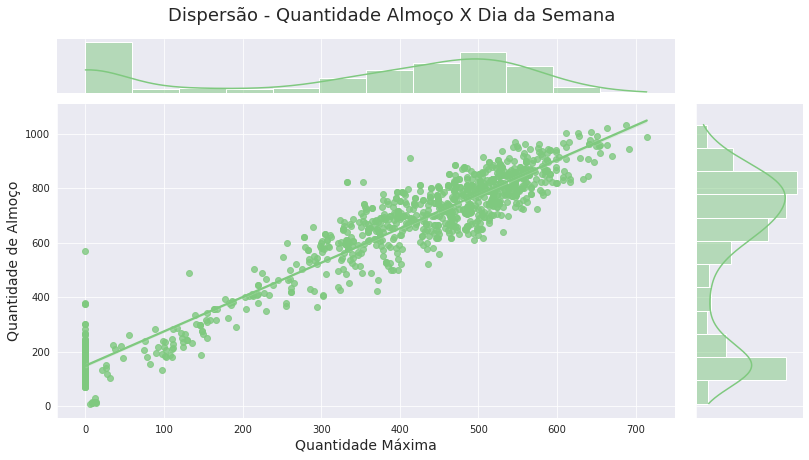

In [ ]:
ax = sns.jointplot(x="Qt_jantar", y="Qt_almoco", data=base_final, kind='reg')
ax.fig.suptitle('Dispersão - Quantidade Almoço X Dia da Semana', fontsize=18, y=1.05)
ax.set_axis_labels("Quantidade Máxima", "Quantidade de Almoço", fontsize=14)
ax.figure.set_size_inches(12,6)

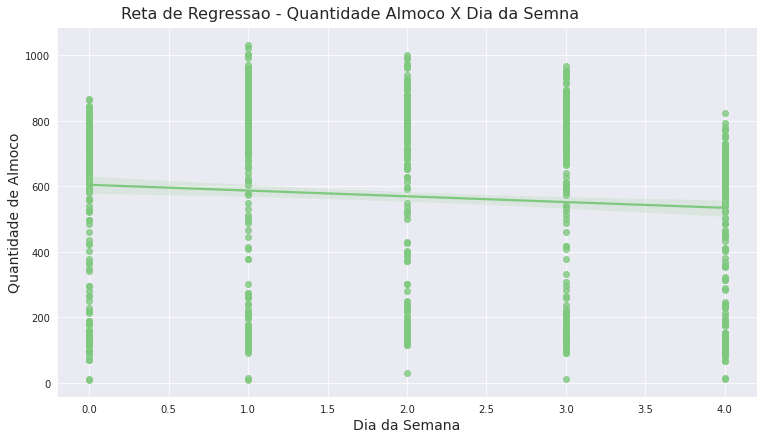

In [ ]:
ax= sns.lmplot(x="dia", y="Qt_almoco", data=base_final)
ax.fig.suptitle('Reta de Regressao - Quantidade Almoco X Dia da Semna', fontsize=16, y=1.02)
ax.set_xlabels("Dia da Semana", fontsize=14)
ax.set_ylabels("Quantidade de Almoco", fontsize=14)
ax.figure.set_size_inches(12,6)

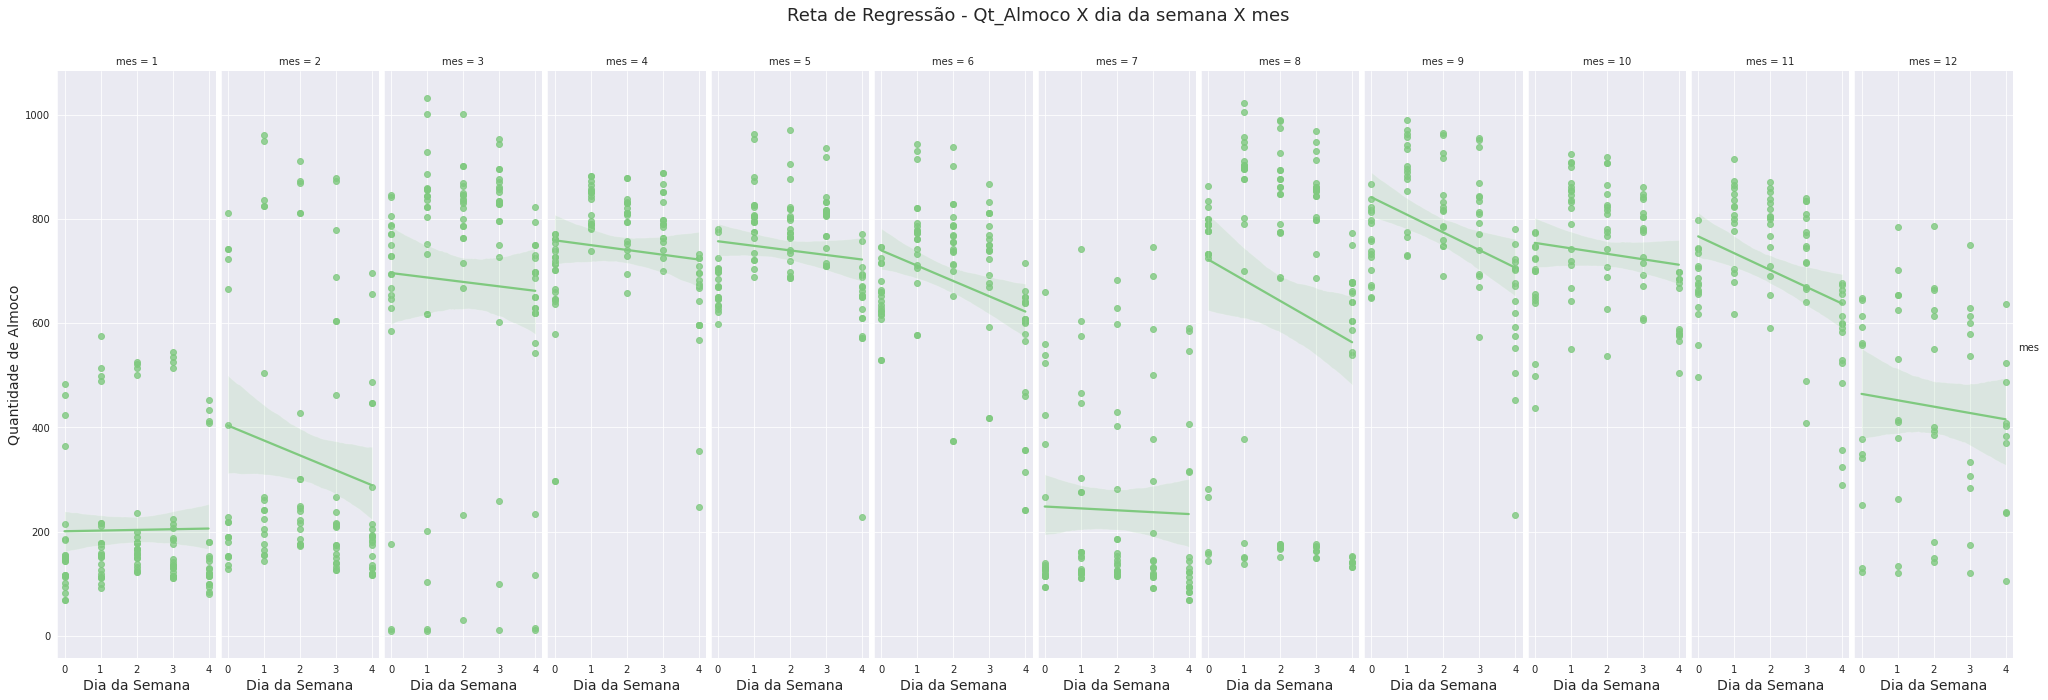

In [ ]:
ax = sns.lmplot(x="dia", y="Qt_almoco", data=base_final, col="mes", legend=False)
ax.fig.suptitle('Reta de Regressão - Qt_Almoco X dia da semana X mes', fontsize=18, y=1.02)
ax.set_xlabels("Dia da Semana", fontsize=14)
ax.set_ylabels("Quantidade de Almoco", fontsize=14)
ax.add_legend(title="mes")
ax.figure.set_size_inches(28,10)

A função lmplot(), do seaborn, é mais uma ferramenta para análise da dispersão dos dados de um modelo.

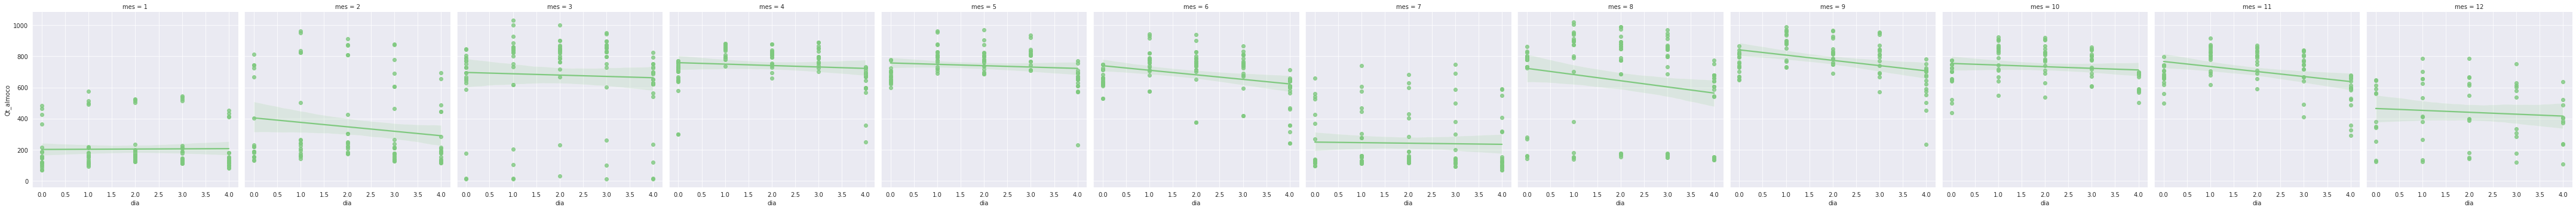

In [ ]:
from pandas.core.internals import base
sns.lmplot(x="dia", y="Qt_almoco", data=base_final, col="mes")

  O objetivo é prever ou estimar o valor médio da variável dependente, tendo antes conhecido o valor das variáveis dependentes. Para tanto, utilizaremos o Scikit-learn, uma biblioteca especializada em machine learing que possui um ferramental completo para esse fim. Inicialmente, separaremos nossos dados em train e test para modelar nossa regressão e testá-la. Importaremos a função train_test_split do sckit-learn para executar esta tarefa.
  Precisaremos dividir o dataframe em series que contém a variável dependente e outro dataframe que contém as variáveis explicativas. Então criaremos:

In [ ]:
y = base_final['Qt_almoco']

In [ ]:
X = base_final[['ano', 'mes', 'dia','Qt_jantar']]

In [ ]:
X

,ano,mes,dia,Qt_jantar
0,2016,1,0,294
1,2016,1,1,363
2,2016,1,2,401
3,2016,1,3,349
4,2016,1,4,218
...,...,...,...,...
1143,2020,3,1,9
1144,2020,3,3,13
1145,2020,3,4,14
1146,2020,3,0,12


Essa função possui como retorno uma lista de quatro itens, e precisamos atribuir a cada elemento da lista o conteúdo das variáveis. O primeiro item da lista é o x de treino, o segundo é o x de teste, depois y de treino e y de teste.

Configuraremos, ainda o test_size como 0.3,que se refere à quantidade de dados que usaremos para teste, então 30% dos dados serão selecionados de forma aleatória para a realização de testes do modelo, já o restante será para treino.

O próximo parâmetro é o random_state. Ao fixarmos um valor, por exempLo 2811, teremos um conjunto de treino e de teste idênticos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2811)

In [ ]:
print(f"Tamanho de X_train: {X_train.shape}")
print(f"Tamanho de X_test: {X_test.shape}")
print(f"Tamanho de y_train: {y_train.shape}")
print(f"Tamanho de y_test: {y_test.shape}")

Tamanho de X_train: (803, 4)
Tamanho de X_test: (345, 4)
Tamanho de y_train: (803,)
Tamanho de y_test: (345,)


In [ ]:
modelo= LinearRegression()

In [ ]:
modelo.fit(X_train, y_train)

LinearRegression()

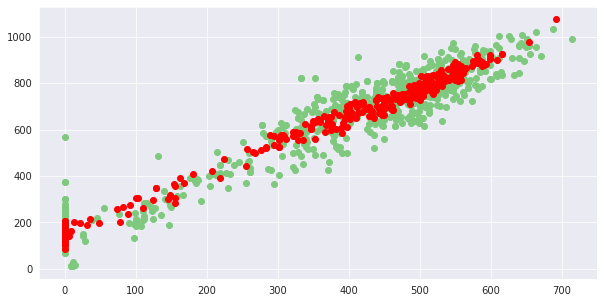

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(X_train['Qt_jantar'],y_train)
plt.scatter(X_test['Qt_jantar'],modelo.predict(X_test),color='red')

Em seguida, calcularemos o coeficiente de determinação, uma medida resumida do grau de ajuste da regra de digressão.

In [ ]:
print('R² = {}'.format(modelo.score(X_train, y_train).round(2)))

R² = 0.95


A medida resumida trabalha com valores entre 0 e 1, então quanto mais próximo de 1 melhor. Podemos testá-lo e gerar previsões para este modelo, o objetivo de todo o processo. Teremos as observações das variáveis explicativas e conseguiremos fazer previsões da variável dependente. Criaremos uma variável chamada y_previsto que receberá modelo. Em seguida, evocamos o método predict() pera realizar de fato a previsão, utilizando como parâmetro X de teste.

Para conseguirmos explicar os resultados que serão obtidos na previsão, utilizaremos o metrics(), e o r2_score().

In [ ]:
y_previsto = modelo.predict(X_test)

In [ ]:
print('R² = %s' % metrics.r2_score(y_test, y_previsto).round(2))

R² = 0.96


Na célula "Dados de Entrada", coletaremos o primeiro registro de X_test, e armazenaremos isso na variável entrada.

In [ ]:
entrada = X_test[0:5]
entrada

,ano,mes,dia,Qt_jantar
221,2016,12,0,155
351,2017,7,1,375
931,2019,5,0,536
201,2016,11,4,295
173,2016,10,2,473


In [ ]:
modelo.predict(entrada)[0]

282.78595848000623

In [ ]:
ano=2017
mes=1
dia=2
Qt_jantar= 155
entrada=[[ano,mes,dia,Qt_jantar]]
print('{0:.2f} quantidade'.format(modelo.predict(entrada)[0]))

337.98 quantidade


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


Intercepto: representa o efeito médio em Y, excluindo os efeitos das outras variáveis do modelo.

In [ ]:
modelo.intercept_

-20974.156053440962

In [ ]:
modelo.coef_

array([10.45030991, -0.85508504, 17.66957276,  1.28631126])

In [ ]:
type(modelo.coef_)

numpy.ndarray

In [ ]:
X.columns

Index(['ano', 'mes', 'dia', 'Qt_jantar'], dtype='object')

Criando uma lista com os nomes das variáveis Modelo

In [ ]:
index = ['Intercepto','ano','mes','dia','Qt_jantar']

Criando um DataFrame para armazenar os coeficientes do modelo

In [ ]:
pd.DataFrame(data=np.append(modelo.intercept_, modelo.coef_), index=index, columns=['Parâmetros'])

,Parâmetros
Intercepto,-20974.156053
ano,10.450310
mes,-0.855085
dia,17.669573
Qt_jantar,1.286311


Coeficientes estimados:intercepto seria ao se considerar a exclusão do efeito das variáveis explicativas.

Já estimamos nosso modelo, geramos previsões em um pequeno simulador, aprenderemos a interpretar os coeficientes dessas regressão e agora precisamos fazer algumas análises gráficas sobre o resultado dessas previsões.

Geraremos previsões do modelo para os dados de treino

In [ ]:
y_previsto_train = modelo.predict(X_train)

Gráfico de dispersão entre o valor estimado e o valor real

Text(0, 0.5, 'Quantidade de Almoco- Real')

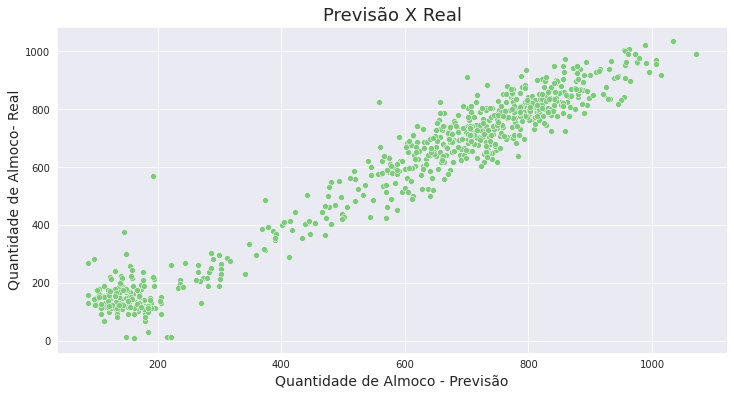

In [ ]:
ax = sns.scatterplot(x=y_previsto_train, y=y_train)
ax.figure.set_size_inches(12, 6)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('Quantidade de Almoco - Previsão', fontsize=14)
ax.set_ylabel('Quantidade de Almoco- Real', fontsize=14)

In [ ]:
residuo = y_train - y_previsto_train

Text(0, 0.5, 'Quantidade de Almoco- Real')

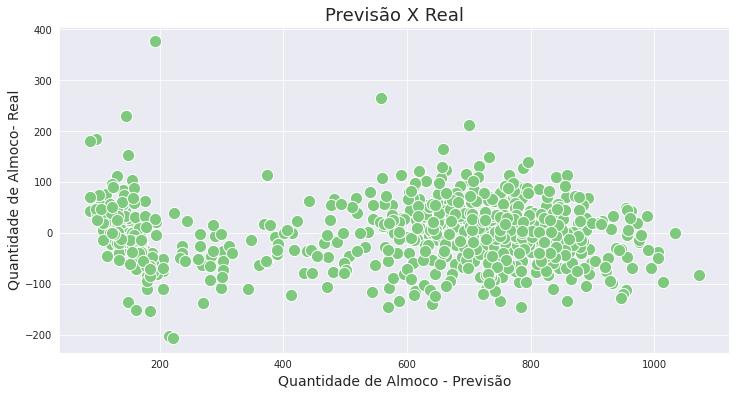

In [ ]:
ax = sns.scatterplot(x=y_previsto_train, y=residuo, s= 150)
ax.figure.set_size_inches(12, 6)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('Quantidade de Almoco - Previsão', fontsize=14)
ax.set_ylabel('Quantidade de Almoco- Real', fontsize=14)

Em nosso gráfico, vemos que a variação ocorre de forma mais expressiva quando estamos lidando com valores maiores, e não uma constante variação em todo o processo.

Podemos criar um outro gráfico com os resíduos elevados ao quadrado, para isso, incluiremos **2 no parâmetro y=residuo.

Text(0, 0.5, 'Quantidade de Almoco- Real')

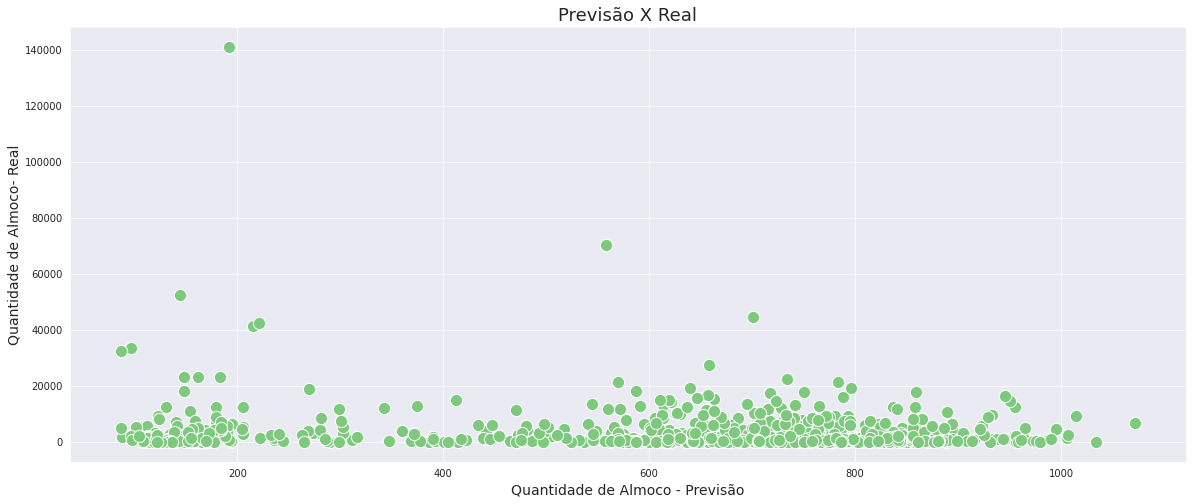

In [ ]:
ax = sns.scatterplot(x=y_previsto_train, y=residuo**2, s=150)
ax.figure.set_size_inches(20, 8)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('Quantidade de Almoco - Previsão', fontsize=14)
ax.set_ylabel('Quantidade de Almoco- Real', fontsize=14)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Quantidade')

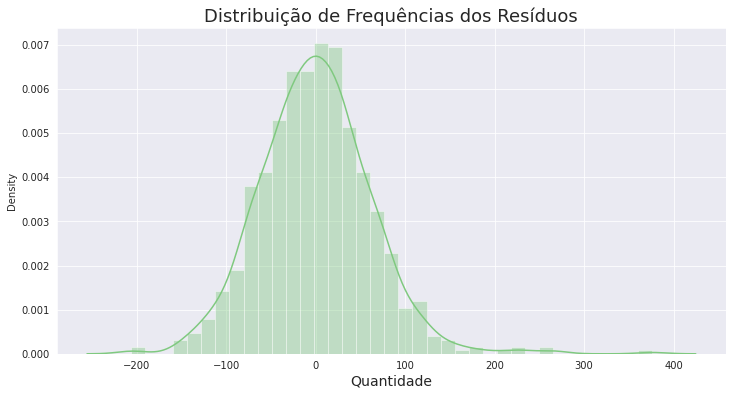

In [ ]:
ax = sns.distplot(residuo)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências dos Resíduos', fontsize=18)
ax.set_xlabel('Quantidade', fontsize=14)

A média dos quadrados dos erros, ou erro quadrático médio trata-se do resíduo elevado ao quadrado e obter a média desses elementos, teremos, portanto, uma informação da quantidade ao quadrado. Teremos também a variação média do erro dessa previsão, em quantidade unitária.

Floresta Aleatória (*Random Forest*)

**Objetivos**: Aprender o que é Floresta Aleatória usando a biblioteca `Scikit-Learn`.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 2, random_state = 2811).fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
predict = regressor.predict(X_test)
mse = mean_squared_error(y_test, predict)
rmse = mse**.5
print(mse)
print(rmse)


9803.252744345784
99.0113768429961


In [ ]:
y_pred =regressor.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.8734743754913697

## Regressão com a os dados do Jantar

### Usando Regressão Linear

In [ ]:
base_final

,Data,Qt_almoco,Qt_jantar,ano,mes,dia
0,2016-01-04,364,294,2016,1,0
1,2016-01-05,489,363,2016,1,1
2,2016-01-06,522,401,2016,1,2
3,2016-01-07,514,349,2016,1,3
4,2016-01-08,409,218,2016,1,4
...,...,...,...,...,...,...
1143,2020-03-24,10,9,2020,3,1
1144,2020-03-26,11,13,2020,3,3
1145,2020-03-27,15,14,2020,3,4
1146,2020-03-30,13,12,2020,3,0


In [ ]:
#renomeando algumas colunas
base_final = base_final.rename(columns={'dia': 'dia_semana'})

In [ ]:
base_final['dia'] = base_final.index
base_final

,Data,Qt_almoco,Qt_jantar,ano,mes,dia_semana,dia
0,2016-01-04,364,294,2016,1,0,0
1,2016-01-05,489,363,2016,1,1,1
2,2016-01-06,522,401,2016,1,2,2
3,2016-01-07,514,349,2016,1,3,3
4,2016-01-08,409,218,2016,1,4,4
...,...,...,...,...,...,...,...
1143,2020-03-24,10,9,2020,3,1,1143
1144,2020-03-26,11,13,2020,3,3,1144
1145,2020-03-27,15,14,2020,3,4,1145
1146,2020-03-30,13,12,2020,3,0,1146


In [ ]:
#alterando a ordem das colunas
base_final = base_final[['dia', 'Data', 'ano', 'mes', 'dia_semana', 'Qt_almoco', 'Qt_jantar']]
base_final

,dia,Data,ano,mes,dia_semana,Qt_almoco,Qt_jantar
0,0,2016-01-04,2016,1,0,364,294
1,1,2016-01-05,2016,1,1,489,363
2,2,2016-01-06,2016,1,2,522,401
3,3,2016-01-07,2016,1,3,514,349
4,4,2016-01-08,2016,1,4,409,218
...,...,...,...,...,...,...,...
1143,1143,2020-03-24,2020,3,1,10,9
1144,1144,2020-03-26,2020,3,3,11,13
1145,1145,2020-03-27,2020,3,4,15,14
1146,1146,2020-03-30,2020,3,0,13,12


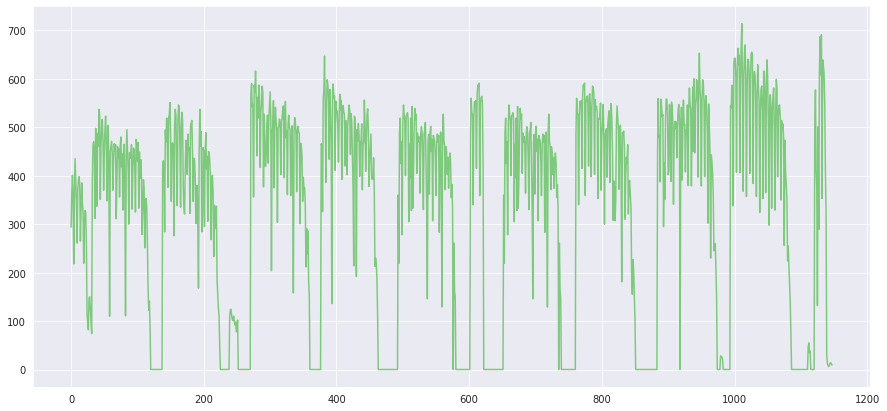

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(base_final['dia'], base_final['Qt_jantar'])

In [ ]:
y = base_final['Qt_jantar']
X = base_final[['dia', 'dia_semana', 'Qt_almoco']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2811)

In [ ]:
linearRegressionFunction= LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [ ]:
print('R² = {}'.format(modelo.score(X_train, y_train).round(2)))

R² = 0.95


In [ ]:
y_predict = modelo.predict(X_test)

Text(0.5, 1.0, 'Quantidade de jantares tidos e previstos')

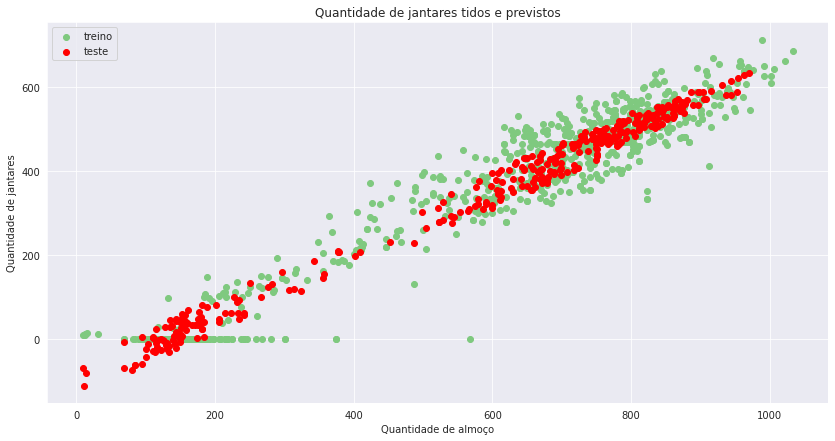

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(X_train['Qt_almoco'], y_train)
plt.scatter(X_test['Qt_almoco'], y_predict, color='red')
plt.legend(['treino' , 'teste'])
plt.xlabel('Quantidade de almoço')
plt.ylabel('Quantidade de jantares')
plt.title('Quantidade de jantares tidos e previstos')

### Usando Floresta Aleatória

In [ ]:
florestaAleatoriaFunction = RandomForestRegressor(n_estimators = 50, max_features = 'sqrt', max_depth = 2, random_state = 2811)

In [ ]:
florestaAleatoriaFunction.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, max_features='sqrt', n_estimators=50,
                      random_state=2811)

In [ ]:
y_pred = florestaAleatoriaFunction.predict(X_test)

In [ ]:
r2_score(y_test,y_pred)

0.7820940976812605

Text(0.5, 1.0, 'Quantidade de jantares tidos e previstos')

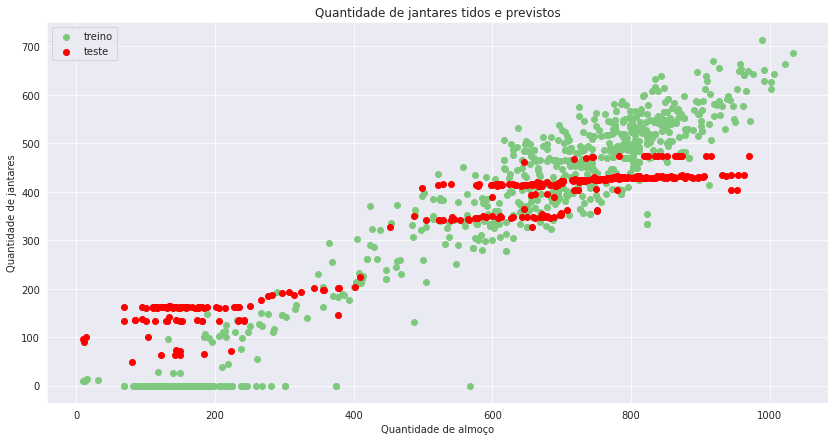

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(X_train['Qt_almoco'], y_train)
plt.scatter(X_test['Qt_almoco'], y_pred, color='red')
plt.legend(['treino' , 'teste'])
plt.xlabel('Quantidade de almoço')
plt.ylabel('Quantidade de jantares')
plt.title('Quantidade de jantares tidos e previstos')



## Series Temporais



Implementação Series Temporais.
Analisando os dados do dataframe percebemos que a coluna Data é do tipo object e teremos que alterar para Datetime.

Como mais a frente faremos a analise dos dados referentes a almoço e jantar separadamente, criaremos dataframes para cada um antecipadamente pois precisaremos limpar novamente retirando os valores zero, como foi falado anteriormente so limpamos quando Qt_almoco e Qt_jantar eram zero pois teriam casos que Qt_almoco teria dados mas Qt_jantar não.

## Almoço

In [ ]:
Qt_almoco = base_final_copia[["Data", "Qt_almoco"]]
Qt_almoco

,Data,Qt_almoco
0,2016-01-04,364
1,2016-01-05,489
2,2016-01-06,522
3,2016-01-07,514
4,2016-01-08,409
...,...,...
1143,2020-03-24,10
1144,2020-03-26,11
1145,2020-03-27,15
1146,2020-03-30,13


Limpeza para retirar zeros na coluna Qt_almoco:

In [ ]:
for i in range(len(Qt_almoco)):
  if(Qt_almoco['Qt_almoco'][i] == 0):
    Qt_almoco.drop(i, inplace=True)
Qt_almoco = Qt_almoco.reset_index(drop=True)

In [ ]:
Qt_almoco.Data = pd.to_datetime(Qt_almoco.Data) #Convertendo a coluna Data para o formata de data
Qt_almoco.dtypes

Data         datetime64[ns]
Qt_almoco             int64
dtype: object

Em seguida tranformaremos a coluna Data como coluna indexadora.

In [ ]:
Qt_almoco.set_index('Data', inplace=True)
Qt_almoco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1148 entries, 2016-01-04 to 2020-03-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Qt_almoco  1148 non-null   int64
dtypes: int64(1)
memory usage: 17.9 KB


## Jantar

In [ ]:
Qt_jantar = base_final_copia[["Data", "Qt_jantar"]]

Limpeza para retirar zeros da coluna Qt_jantar:

In [ ]:
for i in range(len(Qt_jantar)):
  if(Qt_jantar['Qt_jantar'][i] == 0):
    Qt_jantar.drop(i, inplace=True)
Qt_jantar = Qt_jantar.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
Qt_jantar.Data = pd.to_datetime(Qt_jantar.Data) #Convertendo a coluna Data para o formata de data
Qt_jantar.dtypes

Data         datetime64[ns]
Qt_jantar             int64
dtype: object

In [ ]:
Qt_jantar.set_index('Data', inplace=True)
Qt_jantar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 893 entries, 2016-01-04 to 2020-03-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Qt_jantar  893 non-null    int64
dtypes: int64(1)
memory usage: 14.0 KB


In [ ]:
base_final = base_final_copia
base_final.Data = pd.to_datetime(base_final.Data) # Convertendo a coluna Data para o formata de data
base_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Data       1148 non-null   datetime64[ns]
 1   Qt_almoco  1148 non-null   int64         
 2   Qt_jantar  1148 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 27.0 KB


In [ ]:
base_final.dtypes

Data         datetime64[ns]
Qt_almoco             int64
Qt_jantar             int64
dtype: object

Em seguida tranformaremos a coluna Data como coluna indexadora.

In [ ]:
base_final.set_index('Data', inplace=True)

In [ ]:
base_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1148 entries, 2016-01-04 to 2020-03-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Qt_almoco  1148 non-null   int64
 1   Qt_jantar  1148 non-null   int64
dtypes: int64(2)
memory usage: 26.9 KB


### Plotando Séries Temporais

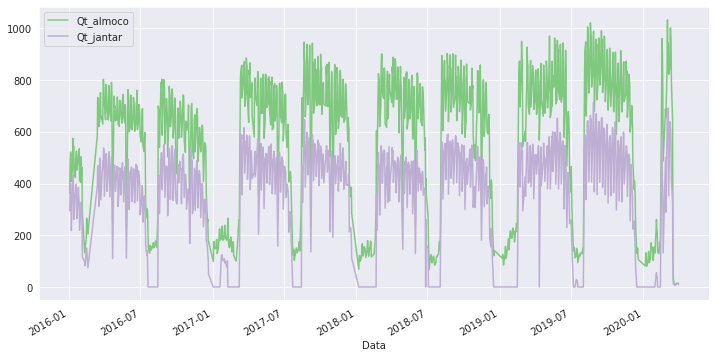

In [ ]:
base_final.plot(figsize=(12,6))

Podemos observar dois comportamentos distintos e também percebemos que sempre a quantidade de almoço sobressai a quantidade de jantar.

### Analisando Tendencias
Faremos a analise dos dados referentes a almoço e jantar, iniciando pelo almoço.


#### Almoço


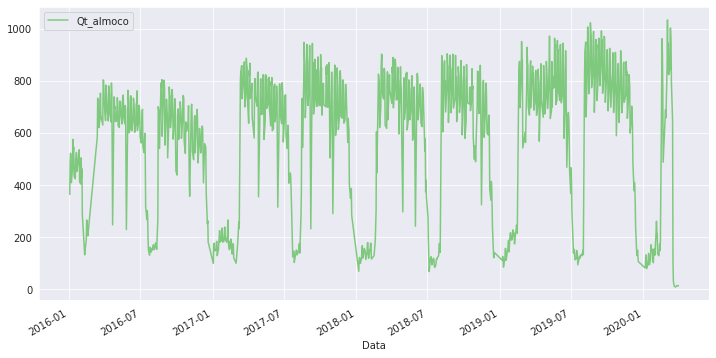

In [ ]:
Qt_almoco.plot(figsize=(12,6))

A componente de tendencia em uma série temporal está associada como é o comportamento no intervalo de tempo.
Em uma série temporal tem duas componentes de tendencia, comportamneto da curva na média, e também o componente de ruído que pode estar relacionado a uma sazonalidade como também pelo próprio ruído da variavel.
Podemos perceber pelo gráfico temos ruídos e para analisar a tendencia precisamos eliminar os ruídos e uma forma de eliminação é aplicando Média Móvel na série.

In [ ]:
Qt_almoco.rolling(12).mean() #APlicando rolling para médias moveis no período de 6 meses

,Qt_almoco
Data,
2016-01-04,NaN
2016-01-05,NaN
2016-01-06,NaN
2016-01-07,NaN
2016-01-08,NaN
...,...
2020-03-24,519.083333
2020-03-26,451.416667
2020-03-27,382.416667


Temos valores NaN porque só conseguimos calcular  a média móvel a partir da 12ª posição.

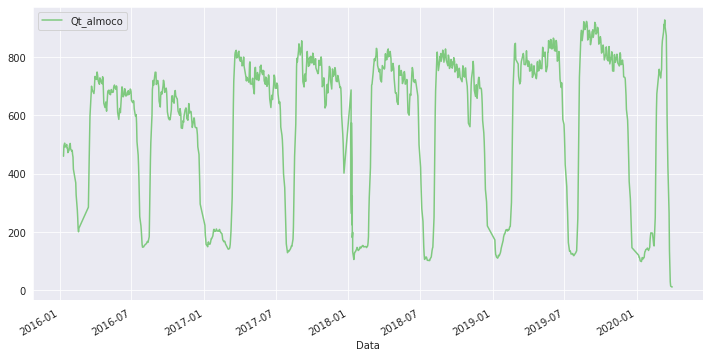

In [ ]:
Qt_almoco.rolling(6).mean().plot(figsize=(12,6))

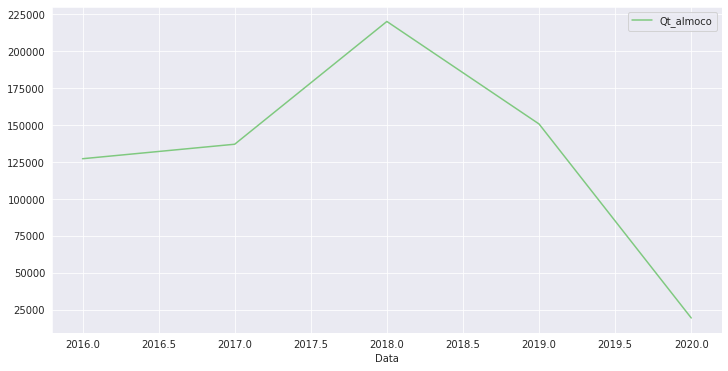

In [ ]:
Qt_almoco.groupby(Qt_almoco.index.year).sum().plot(figsize=(12,6)) #olhar depois

#### Jantar


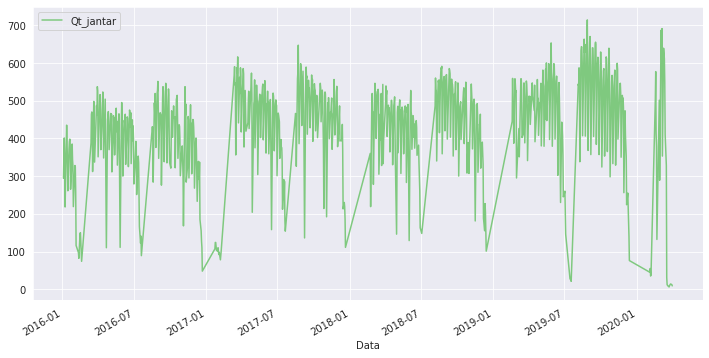

In [ ]:
Qt_jantar.plot(figsize=(12,6))

In [ ]:
Qt_jantar.rolling(6).mean()

,Qt_jantar
Data,
2016-01-04,NaN
2016-01-05,NaN
2016-01-06,NaN
2016-01-07,NaN
2016-01-08,NaN
...,...
2020-03-24,65.833333
2020-03-26,13.333333
2020-03-27,10.500000


Temos valores NaN porque só conseguimos calcular  a média móvel a partir da 12ª posição.

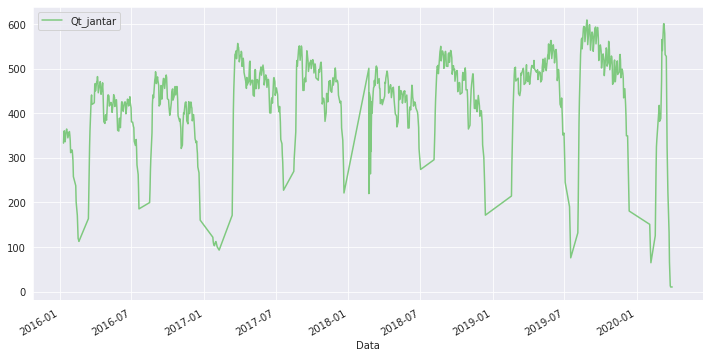

In [ ]:
Qt_jantar.rolling(6).mean().plot(figsize=(12,6))

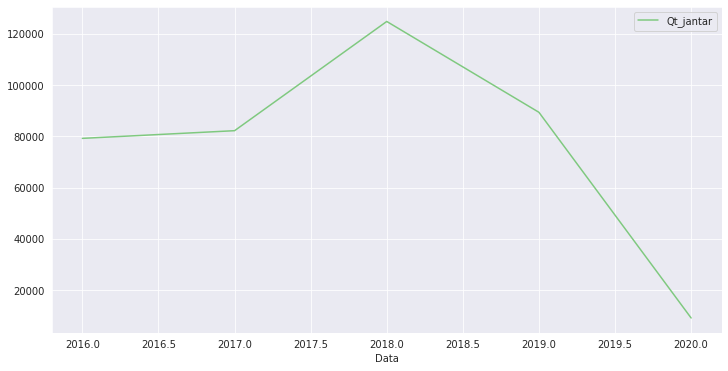

In [ ]:
Qt_jantar.groupby(Qt_jantar.index.year).sum().plot(figsize=(12,6))

### Analisando Sazonalidade
Faremos a analise dos dados referentes a almoço e jantar, iniciando pelo almoço.


#### Almoço


Para analizamos a sazonalidade iremos aplicar diferenças Sucessivas



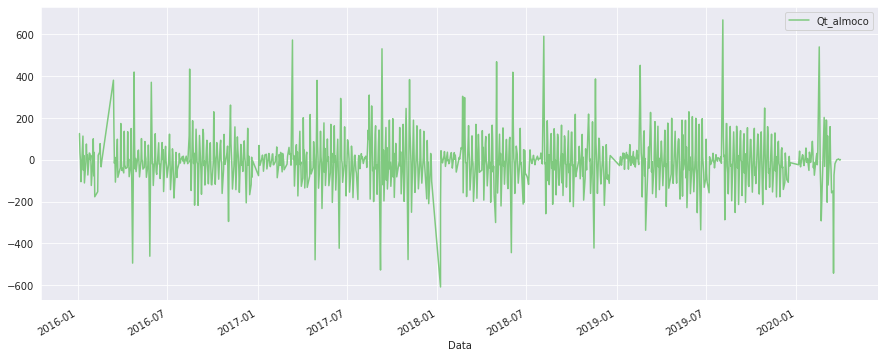

In [ ]:
Qt_almoco.diff().plot(figsize=(15,6))

Agora temos uma serie estacionaria, sem a componente de tendencia. Facilitando a analise da sazonalidade


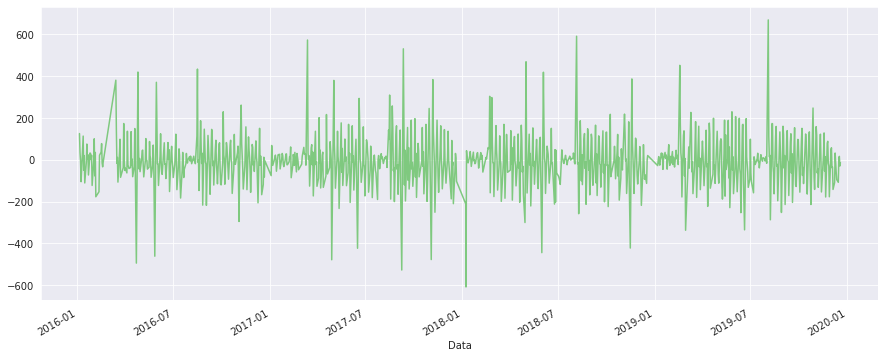

In [ ]:
## Aplicando um filtro para retirar dados refrentes ao ano de 2020
filtro = (Qt_almoco.index.year >= 2016) & (Qt_almoco.index.year <= 2019)
Qt_almoco[filtro].Qt_almoco.diff().plot(figsize=(15,6))

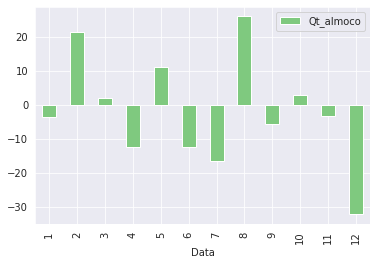

In [ ]:
# Podemos agrupar os dados por mês para verificamos se existe uma zasonalidade mensal ou não
Qt_almoco.diff().groupby(Qt_almoco.index.month).mean().plot(kind='bar')

Ao analizar o grafico acima, notamos que nos meses de Feveiro e Agosto em meia ha um aumento no numero de almoços, o que pode ser explicado pelo fato de ser inicio de semestre.


#### Jantar

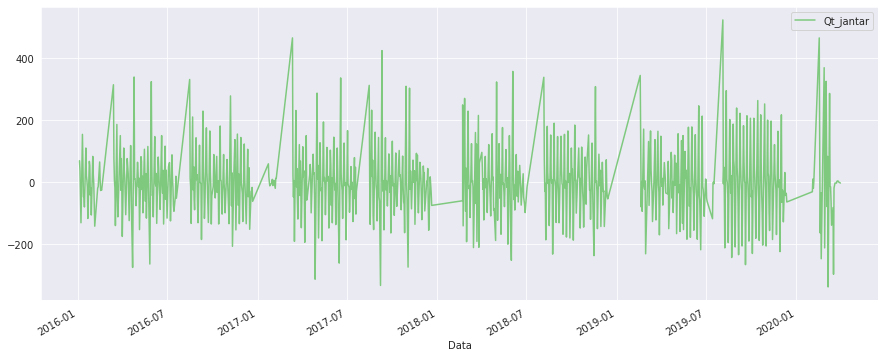

In [ ]:
Qt_jantar.diff().plot(figsize=(15,6))

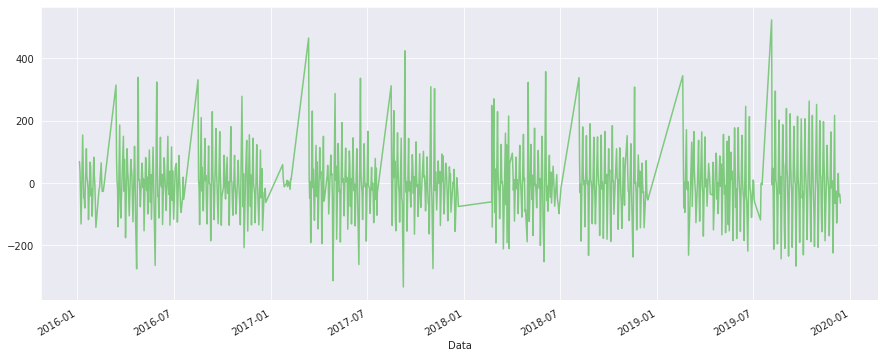

In [ ]:
## Aplicando um filtro para retirar dados refrentes ao ano de 2020
filtro = (Qt_jantar.index.year >= 2016) & (Qt_jantar.index.year <= 2019)
Qt_jantar[filtro].Qt_jantar.diff().plot(figsize=(15,6))

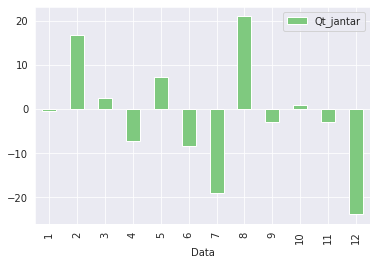

In [ ]:
# Podemos agrupar os dados por mês para verificamos se existe uma zasonalidade mensal ou não
Qt_jantar.diff().groupby(Qt_jantar.index.month).mean().plot(kind='bar')

###Aplicandos os Modelos de predição
Faremos a analise dos dados referentes a almoço e jantar, iniciando pelo almoço.


#### Autocorrelação Total e Parcial

In [ ]:
base_final.head()

,Qt_almoco,Qt_jantar
Data,,
2016-01-04,364,294
2016-01-05,489,363
2016-01-06,522,401
2016-01-07,514,349
2016-01-08,409,218


Para criar os gráficos de autocorrelação parcial e total, utilizaremos as funções plot_pacf() e plot_acf().

Para a correção de bugs na criação do gráfico, acrescentaremos o comando plt.show().

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


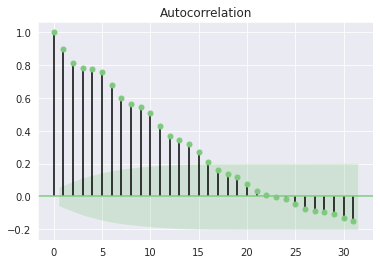

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(base_final.Qt_almoco)
plt.show()

Para analisar a autocorrelação parcial utilizamos o gráfico de autocorrelação parcial. Definiremos o parâmetro lags=10, para exibir somente os 10 primeiros lags.

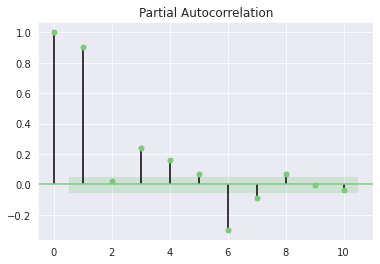

In [ ]:
plot_pacf(base_final.Qt_almoco, lags=10)
plt.show()

#### ARMA



*   Almoço



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

base_final.head()

,Qt_almoco,Qt_jantar
Data,,
2016-01-04,364,294
2016-01-05,489,363
2016-01-06,522,401
2016-01-07,514,349
2016-01-08,409,218


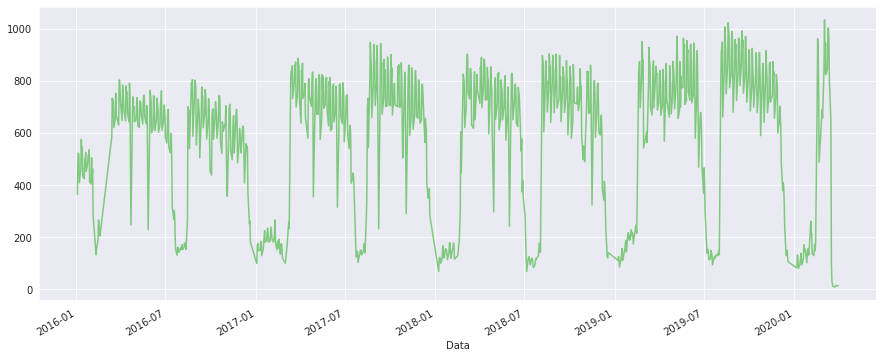

In [ ]:
base_final.Qt_almoco.plot(figsize=(15,6))

## 5. I**N**terpret (Interpretação)





### Biblioteca Altair

In [ ]:
!pip install vega_datasets

In [ ]:
import altair as alt

In [ ]:
!pip install altair

Depois da organização de todos os dados obtidos através do “DataSet-RU”, foi possível fazer as seguintes análises do comportamentos dos usuários do Restaurante Universitário da Universidade Federal do Ceará, situada em Sobral-CE:



1.Normalmente, em média, há 5 momentos em cada semestre que o Restaurante Universitário apresenta almoço e janta nulos.

Os vales em cada gráfico são devidos em grande parte a feriados, mas não apenas a isso, como eventos separados também influenciando o comportamento dos gráficos.





In [ ]:
alt.Chart(base_final).mark_point(size=50).encode(
    x = 'Qt_almoco',
    y = 'Data'


).properties(
    title = 'Dados Ru Almoço'
).interactive()

alt.Chart(...)

In [ ]:
alt.Chart(base_final).mark_point(size=50).encode(
    x = 'Qt_jantar',
    y = 'Data'


).properties(
    title = 'Dados Ru Jantar'
).interactive()

alt.Chart(...)

2.	Durante a semana, os dias onde o Restaurante Universitário é mais utilizado é na Terça e Quarta-feira e também é percebido o momento de menor uso, que é nas Sextas-feiras no período da janta.

O início de Abril de 2016 será utilizado como representação, mas as outras semanas quase que em suas totalidades tem o mesmo comportamento, onde às Terças e Quartas tem o maior fluxo de usuários e no período da janta às Sextas é o momento com menor demanda. Tal comportamento se deve, sem sua maioria, pela origem dos estudantes que têm suas residências familiares localizadas fora do município de Sobral, e o êxodo de ida e vinda a cada fim de semana causa o fenômeno que ainda às Segundas os alunos estão chegando no município do Campus e às Sextas a noite grande parte já tem ido para os municípios de suas famílias.

In [ ]:
alt.Chart(base_final).mark_bar().encode(
    x = 'Data',
    y = 'Qt_almoco',


).properties(
    title = 'Dados Ru Almoco - Barra'
).interactive()

alt.Chart(...)

In [ ]:
alt.Chart(base_final).mark_bar().encode(
    x = 'Data',
    y = 'Qt_jantar',


).properties(
    title = 'Dados Ru Jantar - Barra'
).interactive()

alt.Chart(...)

3.	Queda livre no uso do Restaurante Universitário com a chegada da reta final de cada semestre.

Pode se perceber que com a chegada do período final do semestre grande parte dos usuários do Restaurante Universitário deixam de ir, as causas são brandas, que vai desde a reprovação nas disciplinas à não haver mais tempo devido aos trabalhos e provas.